<a href="https://colab.research.google.com/github/hemanth346/eva4/blob/master/S6/S6_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learnings / Notes

**Note** there is difference between L1 loss and L1 norm regulaizer

    https://discuss.pytorch.org/t/how-to-create-compound-loss-mse-l1-norm-regularization/17171/3

implementing L1 regularizer(?), still need study. Current implementation may be will use extra memory as it creates new corresponding for every weight in the model

    https://discuss.pytorch.org/t/simple-l2-regularization/139/9?u=hemanth346

    https://discuss.pytorch.org/t/adding-l1-l2-regularization-in-a-convolutional-networks-in-pytorch/7734/3?u=hemanth346

    

### Target :
- Run for 40 epochs for each:
    - without L1/L2 norm
    - with L1 norm
    - with L2 norm
    - with L1 and L2 norm

- draw 2 graphs to show the validation accuracy change and loss change. This graph must have proper legends and it should be clear what we are looking at. 

- find any 25 misclassified images for L1 and L2 models. You MUST show the actual and predicted class names.




In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.Resize((28, 28)), # can be commented as all the data is already in this shape
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples)(for all the input channels), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    #    transforms.Resize((28, 28)), # can be commented as all the data is already in this shape
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
# dataset - Creating train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Model

In [0]:
def conv_block(in_channels, out_channels, dropout=0,*args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels), # < added this
        nn.ReLU(),
        nn.Dropout(dropout)
        )
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = conv_block(in_channels=1, out_channels=10, kernel_size=3, padding=1, dropout=0.01, bias=False) #28, rf 3      
        self.conv2 = conv_block(in_channels=10, out_channels=20, kernel_size=3, dropout=0.06, bias=False) #26, rf 5       
        self.pool = nn.MaxPool2d(2, 2)  #13, rf 6                     
        
        self.conv3 = conv_block(in_channels=20, out_channels=10, kernel_size=3, dropout=0.1, bias=False)  #11, rf 10     
        self.conv4 = conv_block(in_channels=10, out_channels=20, kernel_size=3, dropout=0.1, bias=False)  # 9, rf 14    
        self.conv5 = conv_block(in_channels=20, out_channels=10, kernel_size=3, dropout=0.2, bias=False)  # 7, rf 18   

        # No relu, BN before GAP/Last layer
        self.conv6 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, bias=False) #5, rf 22              

        self.gap = nn.AdaptiveAvgPool2d((1,1)) #1, rf 30                                                                   
        self.pconv1 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, bias=False) #1, rf 30     

    def forward(self, x):
        x = self.pool(self.conv2(self.conv1(x)))

        x = self.conv4(self.conv3(x))
        x = self.conv6(self.conv5(x))
        
        x = self.gap(x)
        x = self.pconv1(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 20, 26, 26]           1,800
       BatchNorm2d-6           [-1, 20, 26, 26]              40
              ReLU-7           [-1, 20, 26, 26]               0
           Dropout-8           [-1, 20, 26, 26]               0
         MaxPool2d-9           [-1, 20, 13, 13]               0
           Conv2d-10           [-1, 10, 11, 11]           1,800
      BatchNorm2d-11           [-1, 10, 11, 11]              20
             ReLU-12           [-1, 10, 11, 11]               0
          Dropout-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = [[],[],[],[]]
train_acc = [[],[],[],[]]
test_losses = [[],[],[],[]]
test_acc = [[],[],[],[]]

def train(model, device, train_loader, optimizer, epoch, L1_weight_decay=0, select_list=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 loss - if required
    if L1_weight_decay:
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.norm
            # reg_loss += param.norm(p=1) # can be viable alternative, but have to experiment
        # below is not memory efficient as it will create new vector everytime
            zero_vector = torch.rand_like(param) * 0
            reg_loss += l1_crit(param, zero_vector)        
        loss += L1_weight_decay * reg_loss  # add L1 norm regularizer 
    train_losses[select_list].append(loss)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[select_list].append(100*correct/processed)

def test(model, device, test_loader, select_list=0):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[select_list].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[select_list].append(100. * correct / len(test_loader.dataset))

In [0]:
# summarize history for accuracy
def plot_history(lists, labels, title=None, xlabel='epochs', ylabel=None, save=False):
    '''
    Take list of sequences and their respective label and plot them
    '''
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    for vals, label in zip(lists, labels):
        plt.plot(vals, label=label)
    plt.legend(loc='best')
    if save:
        if title:
            plt.savefig(title)
            print('Fig Saved')
        else:
            print('Unable to save plot')
    plt.show()


labels = ['No L1 or L2', 'Only L1', 'Only L2', 'Both L1 and L2']


In [0]:
def mis_classfied(model, test_loader, num=25):  
    misclassified_images = torch.rand(25,28,28) * 0
    ground_truth = torch.rand(25,1)*0
    predicted = torch.rand(25,1)*0
    num_false_images = 0

    model.eval()
    device = torch.device("cuda" if use_cuda else "cpu")

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            false_picker = torch.flatten(pred)-target
            index = 0
            for val in false_picker:
                if (val != 0):
                    misclassified_images[num_false_images] = data[index, 0, :, :]
                    ground_truth[num_false_images] = target[index]
                    predicted[num_false_images] = pred[index]
                    num_false_images = num_false_images + 1
                    if (num_false_images >= 25): 
                        break

                index = index + 1
               
            if (num_false_images >= num):
                  break
    return misclassified_images, ground_truth, predicted

In [0]:
def plot_misclassified(misclassified_images, ground_truth, predicted, title=''):
    num_img_rows = 5
    num_img_cols = 5

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.suptitle(title) #super title

    for i in range(25):
        plt.subplot(5,5,i+1)
        # plt.tight_layout()
        plt.imshow(misclassified_images[i,:,:], cmap='gray', interpolation='none')
        plt.title("GT:{}, Pred:{}".format(ground_truth[i].numpy(), predicted[i].numpy()))
        plt.xticks([])
        plt.yticks([])

In [0]:
# EPOCHS = 40
# L2_weight_decay = 0.0005

def run_epochs(EPOCHS=40, L1_weight_decay=0, L2_weight_decay=0, select_list=0):
    model =  Net().to(device)

    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        if epoch < 10:
            print('Learning rate :',0.03)
            optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=L2_weight_decay)
        elif epoch < 25:
            print('Learning rate :',0.003)
            optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=L2_weight_decay)
        else:
            print('Learning rate :',0.0003)
            optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, weight_decay=L2_weight_decay)

        train(model, device, train_loader, optimizer, epoch, L1_weight_decay=0, select_list=select_list)  # quick fix
        test(model, device, test_loader, select_list=select_list) # quick fix
    return model

In [12]:
# No L1 or L2
model = run_epochs()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
Learning rate : 0.03


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.07109617441892624 Batch_id=468 Accuracy=88.88: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 9788/10000 (97.88%)

EPOCH: 1
Learning rate : 0.03


Loss=0.06576476991176605 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9848/10000 (98.48%)

EPOCH: 2
Learning rate : 0.03


Loss=0.045502860099077225 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9867/10000 (98.67%)

EPOCH: 3
Learning rate : 0.03


Loss=0.12595818936824799 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9882/10000 (98.82%)

EPOCH: 4
Learning rate : 0.03


Loss=0.03297989070415497 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 26.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9901/10000 (99.01%)

EPOCH: 5
Learning rate : 0.03


Loss=0.010426844470202923 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9936/10000 (99.36%)

EPOCH: 6
Learning rate : 0.03


Loss=0.04899269714951515 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 7
Learning rate : 0.03


Loss=0.02081921137869358 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 27.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH: 8
Learning rate : 0.03


Loss=0.054741021245718 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 9
Learning rate : 0.03


Loss=0.0015644332161173224 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 10
Learning rate : 0.003


Loss=0.017293667420744896 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 11
Learning rate : 0.003


Loss=0.022304236888885498 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 12
Learning rate : 0.003


Loss=0.012535343877971172 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 13
Learning rate : 0.003


Loss=0.02242596261203289 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

EPOCH: 14
Learning rate : 0.003


Loss=0.011629308573901653 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 15
Learning rate : 0.003


Loss=0.00358137977309525 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 16
Learning rate : 0.003


Loss=0.012629424221813679 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 17
Learning rate : 0.003


Loss=0.014321506023406982 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

EPOCH: 18
Learning rate : 0.003


Loss=0.003414064645767212 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 19
Learning rate : 0.003


Loss=0.002945254324004054 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)

EPOCH: 20
Learning rate : 0.003


Loss=0.0037731181364506483 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 21
Learning rate : 0.003


Loss=0.013630782254040241 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 22
Learning rate : 0.003


Loss=0.12867575883865356 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9946/10000 (99.46%)

EPOCH: 23
Learning rate : 0.003


Loss=0.08675175905227661 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 24
Learning rate : 0.003


Loss=0.012792523019015789 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.007139434572309256 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.022502556443214417 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.004698251839727163 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 27.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.010135511867702007 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.025651762261986732 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.005457515362650156 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.020179197192192078 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.017094889655709267 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9947/10000 (99.47%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.00630180025473237 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.0025060176849365234 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.030554987490177155 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.08675163239240646 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.03287598863244057 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.0037088990211486816 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.009324411861598492 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]



Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


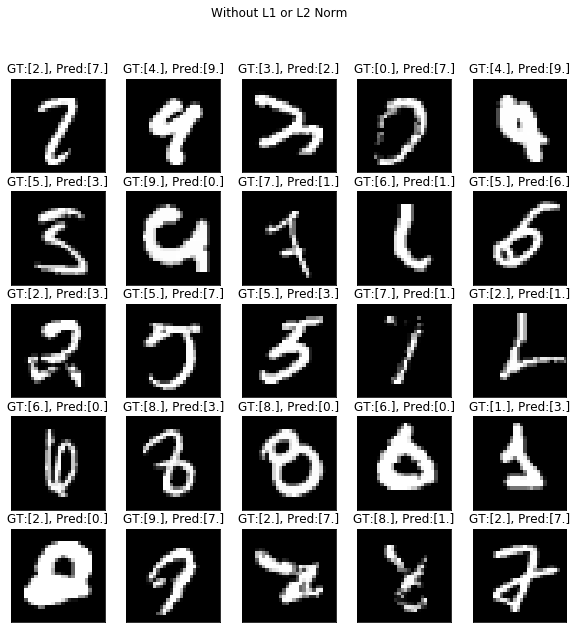

In [13]:
plot_misclassified(*mis_classfied(model, test_loader), 'Without L1 or L2 Norm')

In [14]:
# Only L1
model = run_epochs(L1_weight_decay=0.0005, select_list=1)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
Learning rate : 0.03


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.019905710592865944 Batch_id=468 Accuracy=89.13: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9816/10000 (98.16%)

EPOCH: 1
Learning rate : 0.03


Loss=0.05295996367931366 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9858/10000 (98.58%)

EPOCH: 2
Learning rate : 0.03


Loss=0.12558813393115997 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9895/10000 (98.95%)

EPOCH: 3
Learning rate : 0.03


Loss=0.1047041118144989 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9888/10000 (98.88%)

EPOCH: 4
Learning rate : 0.03


Loss=0.04851159453392029 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9898/10000 (98.98%)

EPOCH: 5
Learning rate : 0.03


Loss=0.013135656714439392 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 6
Learning rate : 0.03


Loss=0.020328834652900696 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

EPOCH: 7
Learning rate : 0.03


Loss=0.017440835013985634 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9907/10000 (99.07%)

EPOCH: 8
Learning rate : 0.03


Loss=0.0694727674126625 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 9
Learning rate : 0.03


Loss=0.026417246088385582 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9901/10000 (99.01%)

EPOCH: 10
Learning rate : 0.003


Loss=0.030328547582030296 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 11
Learning rate : 0.003


Loss=0.00950660277158022 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

EPOCH: 12
Learning rate : 0.003


Loss=0.022900456562638283 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 13
Learning rate : 0.003


Loss=0.008446822874248028 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 14
Learning rate : 0.003


Loss=0.04368333891034126 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 15
Learning rate : 0.003


Loss=0.044933587312698364 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 16
Learning rate : 0.003


Loss=0.008433242328464985 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 17
Learning rate : 0.003


Loss=0.025500347837805748 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 25.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 18
Learning rate : 0.003


Loss=0.04225830361247063 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 19
Learning rate : 0.003


Loss=0.04403151199221611 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 20
Learning rate : 0.003


Loss=0.0027188013773411512 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 21
Learning rate : 0.003


Loss=0.009395003318786621 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 22
Learning rate : 0.003


Loss=0.058287739753723145 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)

EPOCH: 23
Learning rate : 0.003


Loss=0.01700783707201481 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 24
Learning rate : 0.003


Loss=0.06464124470949173 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.015471115708351135 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.03482702001929283 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.07473143935203552 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.0010720888385549188 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.01273172814399004 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.012453918345272541 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9937/10000 (99.37%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.04839654639363289 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.005378305912017822 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.012935519218444824 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.0035804659128189087 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.014419536106288433 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.006985783576965332 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9935/10000 (99.35%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.04694490507245064 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.00351705146022141 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.007512981537729502 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]



Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


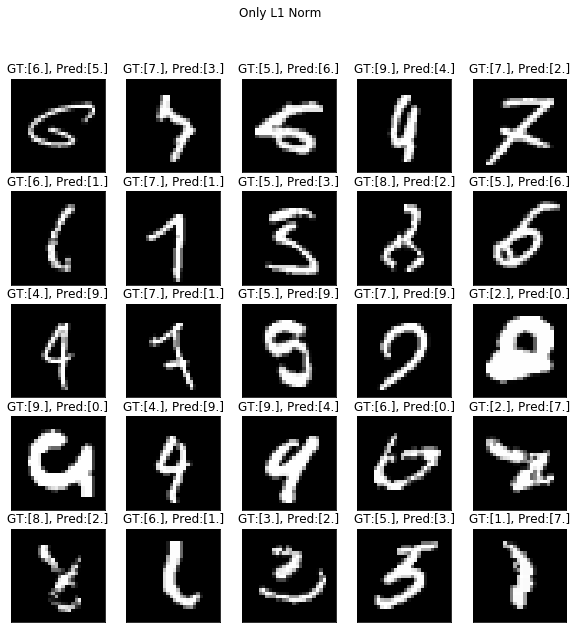

In [15]:
plot_misclassified(*mis_classfied(model, test_loader), 'Only L1 Norm')

In [16]:
# Only L2
model = run_epochs(L2_weight_decay=0.0005, select_list=2)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
Learning rate : 0.03


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.06298243254423141 Batch_id=468 Accuracy=89.22: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9806/10000 (98.06%)

EPOCH: 1
Learning rate : 0.03


Loss=0.012082274071872234 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9866/10000 (98.66%)

EPOCH: 2
Learning rate : 0.03


Loss=0.048477042466402054 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9893/10000 (98.93%)

EPOCH: 3
Learning rate : 0.03


Loss=0.048835139721632004 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9909/10000 (99.09%)

EPOCH: 4
Learning rate : 0.03


Loss=0.06480679661035538 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 5
Learning rate : 0.03


Loss=0.026959111914038658 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 26.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9902/10000 (99.02%)

EPOCH: 6
Learning rate : 0.03


Loss=0.018406331539154053 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)

EPOCH: 7
Learning rate : 0.03


Loss=0.011538833379745483 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9910/10000 (99.10%)

EPOCH: 8
Learning rate : 0.03


Loss=0.03295459970831871 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9910/10000 (99.10%)

EPOCH: 9
Learning rate : 0.03


Loss=0.06715177744626999 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)

EPOCH: 10
Learning rate : 0.003


Loss=0.025787854567170143 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 11
Learning rate : 0.003


Loss=0.03675362840294838 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 12
Learning rate : 0.003


Loss=0.033414050936698914 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 26.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 13
Learning rate : 0.003


Loss=0.026186220347881317 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 14
Learning rate : 0.003


Loss=0.013219743967056274 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 15
Learning rate : 0.003


Loss=0.009672790765762329 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 16
Learning rate : 0.003


Loss=0.003927642945200205 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 17
Learning rate : 0.003


Loss=0.00403363024815917 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 18
Learning rate : 0.003


Loss=0.007364943623542786 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

EPOCH: 19
Learning rate : 0.003


Loss=0.010924135334789753 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 20
Learning rate : 0.003


Loss=0.04297575354576111 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 21
Learning rate : 0.003


Loss=0.01010779570788145 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 22
Learning rate : 0.003


Loss=0.0033288102131336927 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 23
Learning rate : 0.003


Loss=0.022141871973872185 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 24
Learning rate : 0.003


Loss=0.019875293597579002 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.036398496478796005 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.019192278385162354 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.020125458016991615 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9932/10000 (99.32%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.022677531465888023 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.055339958518743515 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.03511326387524605 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.006364906672388315 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 26.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.034090135246515274 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.011107087135314941 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.009025171399116516 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.011265764944255352 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.0032078276854008436 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.028323089703917503 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.008234704844653606 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.006796961184591055 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]



Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


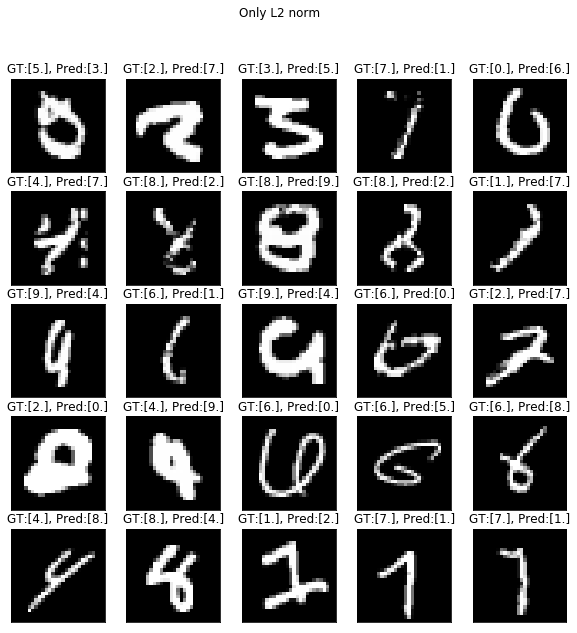

In [17]:
plot_misclassified(*mis_classfied(model, test_loader), 'Only L2 norm')

In [18]:
# Both L2 and L1
model = run_epochs(L1_weight_decay=0.0005, L2_weight_decay=0.0005, select_list=3)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
Learning rate : 0.03


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.036813829094171524 Batch_id=468 Accuracy=89.38: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9793/10000 (97.93%)

EPOCH: 1
Learning rate : 0.03


Loss=0.02966950833797455 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9793/10000 (97.93%)

EPOCH: 2
Learning rate : 0.03


Loss=0.040333036333322525 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9876/10000 (98.76%)

EPOCH: 3
Learning rate : 0.03


Loss=0.06512612849473953 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9890/10000 (98.90%)

EPOCH: 4
Learning rate : 0.03


Loss=0.011745761148631573 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9875/10000 (98.75%)

EPOCH: 5
Learning rate : 0.03


Loss=0.042246121913194656 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9878/10000 (98.78%)

EPOCH: 6
Learning rate : 0.03


Loss=0.08907950669527054 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9883/10000 (98.83%)

EPOCH: 7
Learning rate : 0.03


Loss=0.042901456356048584 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9844/10000 (98.44%)

EPOCH: 8
Learning rate : 0.03


Loss=0.1188974380493164 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9902/10000 (99.02%)

EPOCH: 9
Learning rate : 0.03


Loss=0.010996992699801922 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:21<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9912/10000 (99.12%)

EPOCH: 10
Learning rate : 0.003


Loss=0.03467048704624176 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 11
Learning rate : 0.003


Loss=0.020208893343806267 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 12
Learning rate : 0.003


Loss=0.003036240814253688 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 13
Learning rate : 0.003


Loss=0.013314221985638142 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 14
Learning rate : 0.003


Loss=0.026128580793738365 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 15
Learning rate : 0.003


Loss=0.027188187465071678 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 16
Learning rate : 0.003


Loss=0.1528148204088211 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 17
Learning rate : 0.003


Loss=0.006972938776016235 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 18
Learning rate : 0.003


Loss=0.0053822994232177734 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 19
Learning rate : 0.003


Loss=0.003887395141646266 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

EPOCH: 20
Learning rate : 0.003


Loss=0.01447389554232359 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH: 21
Learning rate : 0.003


Loss=0.0141135947778821 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

EPOCH: 22
Learning rate : 0.003


Loss=0.0027799904346466064 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 23
Learning rate : 0.003


Loss=0.022810710594058037 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 24
Learning rate : 0.003


Loss=0.015319843776524067 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.0035079072695225477 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.008735100738704205 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.023570990189909935 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.016661325469613075 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99.40%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.010373339056968689 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.018902575597167015 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.054731979966163635 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:19<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.028495922684669495 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.013258789665997028 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:19<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.013211305253207684 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.010558267123997211 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.015773454681038857 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.0094274478033185 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.022463807836174965 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.0720757246017456 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


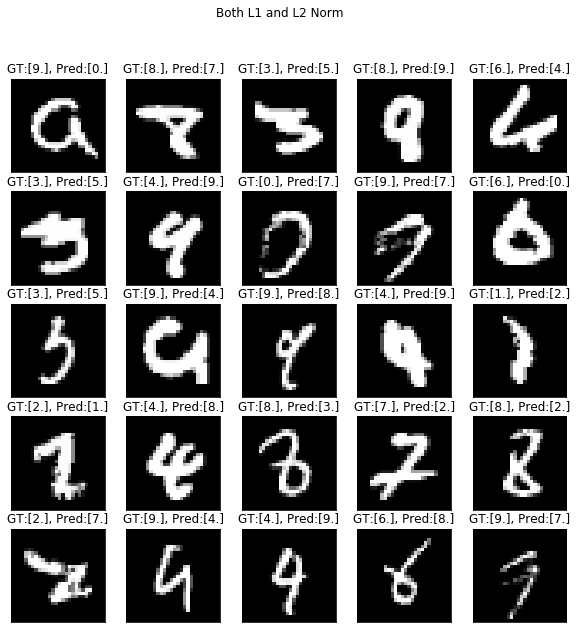

In [19]:
plot_misclassified(*mis_classfied(model, test_loader), 'Both L1 and L2 Norm')

Fig Saved


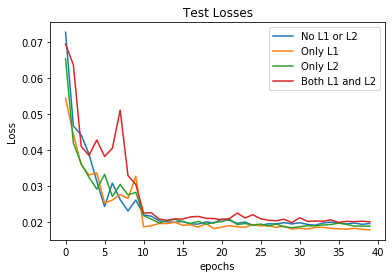

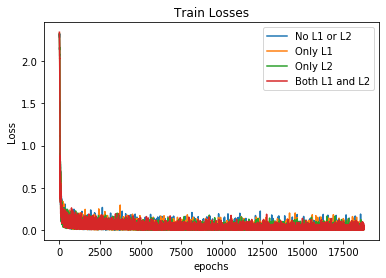

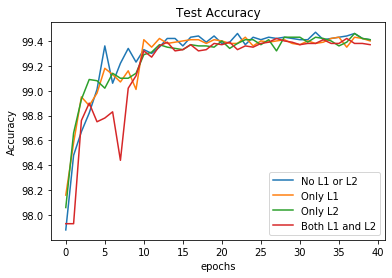

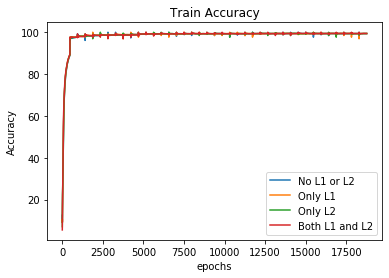

In [20]:
plot_history(test_losses, labels, title='Test Losses', ylabel='Loss', save=1)
plot_history(train_losses, labels, title='Train Losses', ylabel='Loss')
plot_history(test_acc, labels, title='Test Accuracy', ylabel='Accuracy')
plot_history(train_acc, labels, title='Train Accuracy', ylabel='Accuracy')

In [0]:
# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")